In [1]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-07-03 13:46:57.690226: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 13:46:57.774611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 13:46:58.311408: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 13:46:58.312826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 13:46:59.165990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 500

In [3]:
class OFDMModel(tf.keras.Model):
    
    def __init__(self, num_bs_ant):
        super().__init__()

        DELAY_SPREAD = 100e-9
        DIRECTION = 'uplink'
        CDL_MODEL = 'C'
        SPEED = 0.0

        CARRIER_FREQUENCY = 1.9e9

        self.NUM_BITS_PER_SYMBOL = 4
        self.CODERATE = 0.5

        self.NUM_UT = 1
        self.NUM_BS = 1
        self.NUM_UT_ANT = 1
        self.NUM_BS_ANT = num_bs_ant
        self.NUM_STREAMS_PER_TX = self.NUM_UT_ANT

        self.RX_TX_ASSOCIATION = np.array([[1]])
        self.STREAM_MANAGEMENT = sn.mimo.StreamManagement(self.RX_TX_ASSOCIATION, self.NUM_STREAMS_PER_TX)

        self.resource_grid = sn.ofdm.ResourceGrid(
            num_ofdm_symbols=14,
            fft_size=76,
            subcarrier_spacing=30e3,
            num_tx=self.NUM_UT,
            num_streams_per_tx=self.NUM_STREAMS_PER_TX,
            cyclic_prefix_length=6,
            pilot_pattern="kronecker",
            pilot_ofdm_symbol_indices=[2,11]
        )

        self.NUM_CODED_BITS = int(self.resource_grid.num_data_symbols * self.NUM_BITS_PER_SYMBOL)
        self.NUM_INFO_BITS = int(self.NUM_CODED_BITS * self.CODERATE)

        ut_array = sn.channel.tr38901.Antenna(
            polarization='single',
            polarization_type='V',
            antenna_pattern='omni',
            carrier_frequency=CARRIER_FREQUENCY
        )

        bs_array = sn.channel.tr38901.AntennaArray(
            num_rows=1,
            num_cols=self.NUM_BS_ANT,
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='38.901',
            carrier_frequency=CARRIER_FREQUENCY
        )

        self.cdl = sn.channel.tr38901.CDL(
            CDL_MODEL,
            DELAY_SPREAD,
            CARRIER_FREQUENCY,
            ut_array=ut_array,
            bs_array=bs_array,
            direction=DIRECTION,
            min_speed=SPEED
        )


        constellation = sn.utils.Constellation('qam', self.NUM_BITS_PER_SYMBOL)

        self.binary_source = sn.utils.BinarySource()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.NUM_INFO_BITS, self.NUM_CODED_BITS)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=self.encoder, hard_out=True)

        self.mapper = sn.mapping.Mapper('qam', self.NUM_BITS_PER_SYMBOL)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)

        self.rg_mapper = sn.ofdm.ResourceGridMapper(self.resource_grid)

        self.ls_est = sn.ofdm.LSChannelEstimator(resource_grid=self.resource_grid, interpolation_type='nn')

        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(self.resource_grid, self.STREAM_MANAGEMENT)


        self.channel = sn.channel.OFDMChannel(
            self.cdl,
            self.resource_grid,
            add_awgn=True,
            normalize_channel=True,
        )

    @tf.function
    def __call__(self, batch_size, ebno_db):

        no = sn.utils.ebnodb2no(
            ebno_db,
            self.NUM_BITS_PER_SYMBOL,
            self.CODERATE,
            self.resource_grid
        )

        bits = self.binary_source([batch_size, self.NUM_UT, self.resource_grid.num_streams_per_tx, self.NUM_INFO_BITS])
        
        codewords = self.encoder(bits)
        
        qam_symbols = self.mapper(codewords)
        
        ofdm_symbols = self.rg_mapper(qam_symbols)
          
        response = self.channel([ofdm_symbols, no])

        estimation, err_var = self.ls_est([response, no])
        
        equalized_symbols, no_eff = self.lmmse_equ([response, estimation, err_var, no])

        llr = self.demapper([equalized_symbols, no_eff])
        
        bits_hat = self.decoder(llr)

        return bits, bits_hat

In [4]:
ber_plots = sn.utils.PlotBER('OFDM')
EBNO_DBS = np.linspace(-5,10,16)

model_1 = OFDMModel(2)
model_2 = OFDMModel(4)
model_3 = OFDMModel(8)


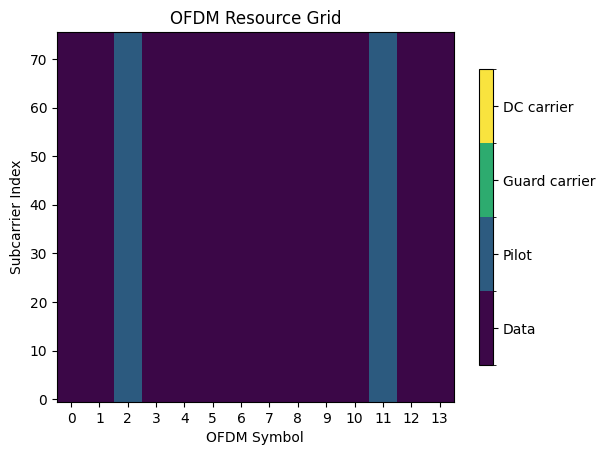

In [6]:
model_1.resource_grid.show();

In [5]:
ber_plots.simulate(
    model_1,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='2 BS ANTENNAS',
    soft_estimates=False,
    max_mc_iter=100,
    show_fig=False
);

2023-07-03 03:19:29.124437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.8696e-01 | 1.0000e+00 |      352908 |      912000 |          500 |         500 |        12.6 |reached target bit errors
     -4.0 | 3.6457e-01 | 1.0000e+00 |      332490 |      912000 |          500 |         500 |         3.5 |reached target bit errors
     -3.0 | 3.4252e-01 | 1.0000e+00 |      312378 |      912000 |          500 |         500 |         3.4 |reached target bit errors
     -2.0 | 3.1713e-01 | 1.0000e+00 |      289222 |      912000 |          500 |         500 |         3.3 |reached target bit errors
     -1.0 | 2.8842e-01 | 1.0000e+00 |      263040 |      912000 |      

In [6]:
ber_plots.simulate(
    model_2,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='4 BS ANTENNAS',
    soft_estimates=False,
    max_mc_iter=100,
    show_fig=False
);

2023-07-03 03:35:58.615765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.6670e-01 | 1.0000e+00 |      334430 |      912000 |          500 |         500 |         8.0 |reached target bit errors
     -4.0 | 3.4754e-01 | 1.0000e+00 |      316956 |      912000 |          500 |         500 |         4.1 |reached target bit errors
     -3.0 | 3.2596e-01 | 1.0000e+00 |      297276 |      912000 |          500 |         500 |         4.2 |reached target bit errors
     -2.0 | 3.0153e-01 | 1.0000e+00 |      274996 |      912000 |          500 |         500 |         4.2 |reached target bit errors
     -1.0 | 2.7570e-01 | 1.0000e+00 |      251438 |      912000 |          500 |         500 |         4.1 |reached target bit errors
      0.0 | 2.4566e-01 | 1.0000e+00 |      224045 |      912000 |          

In [7]:
ber_plots.simulate(
    model_3,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='8 BS ANTENNAS',
    soft_estimates=False,
    max_mc_iter=100,
    show_fig=False
);

2023-07-03 03:49:43.390811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.6620e-01 | 1.0000e+00 |      333974 |      912000 |          500 |         500 |        10.0 |reached target bit errors
     -4.0 | 3.4874e-01 | 1.0000e+00 |      318052 |      912000 |          500 |         500 |         6.4 |reached target bit errors
     -3.0 | 3.2820e-01 | 1.0000e+00 |      299317 |      912000 |          500 |         500 |         6.4 |reached target bit errors
     -2.0 | 3.0468e-01 | 1.0000e+00 |      277865 |      912000 |          500 |         500 |         6.5 |reached target bit errors
     -1.0 | 2.7769e-01 | 1.0000e+00 |      253255 |      912000 |          500 |         500 |         6.4 |reached target bit errors
      0.0 | 2.4321e-01 | 1.0000e+00 |      221803 |      912000 |          

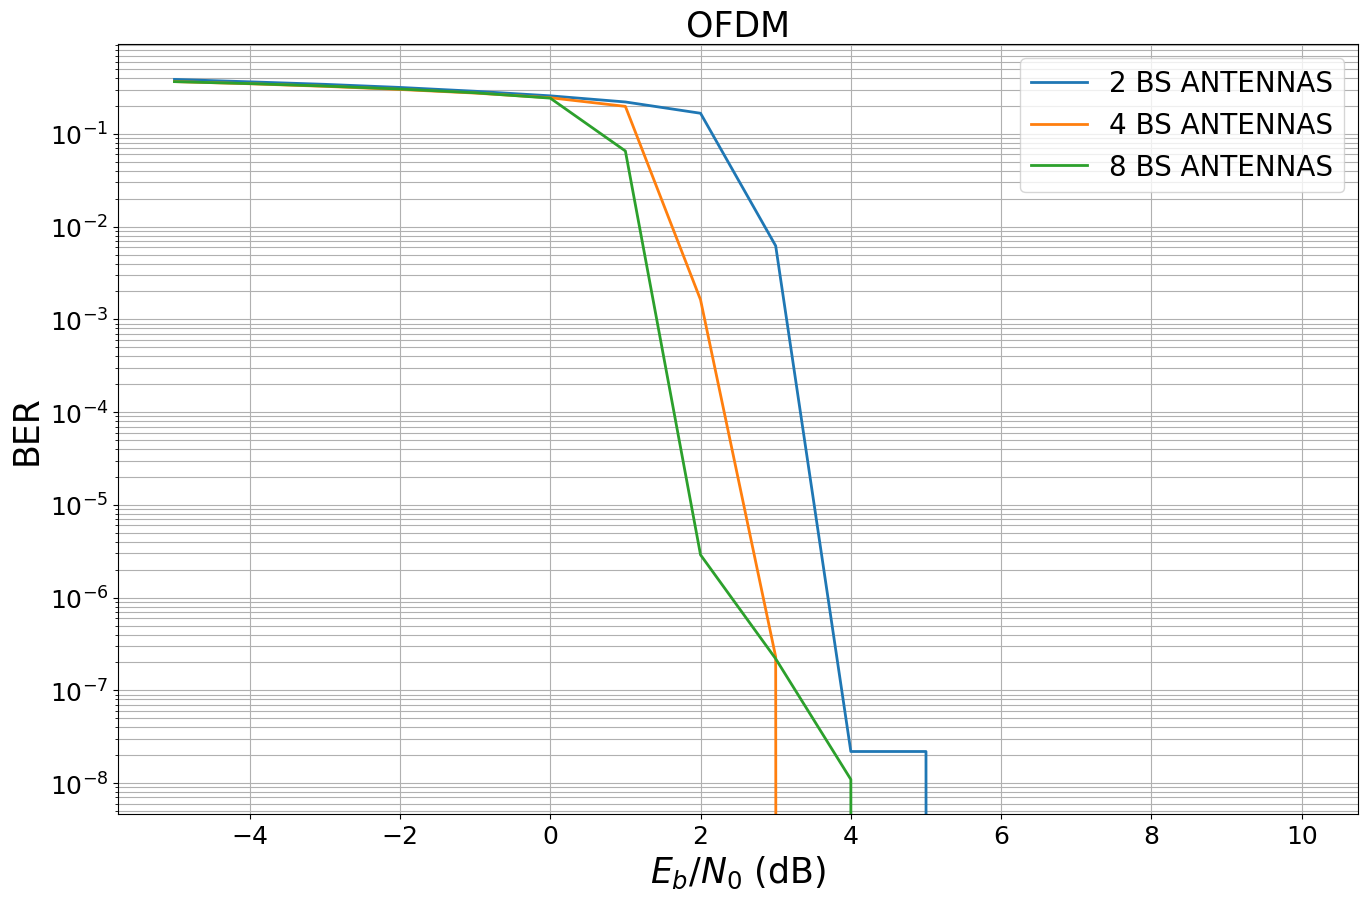

In [8]:
ber_plots()